## 🏠 House Prices - Random Forest 

### Destaques do Random Forest  

* **Pré-processamento inicial:** leitura dos dados e remoção de colunas com mais de 10% de valores ausentes, garantindo um conjunto de treino consistente e sem variáveis excessivamente incompletas.

* **Transformação das variáveis:** aplicação de imputação por mediana e padronização nas variáveis numéricas, enquanto as categóricas são convertidas via One-Hot Encoding. Todo o fluxo é integrado em um único ColumnTransformer para assegurar coerência durante treino e inferência.

* **Treinamento do modelo:** construção de um pipeline com o RandomForest,sem ajustes hiperparâmetros e com ajuste. O modelo é treinado utilizando a variável alvo em escala logarítmica para maior estabilidade e desempenho preditivo.



## 1. Bibliotecas

In [1]:
# =====================================================
# 🏠 House Prices - Random Forest 
# =====================================================
import pandas as pd

# Scikit-learn - Modelos ensemble
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from pathlib import Path
from setup_notebook import setup_path
setup_path()
from src.model_utils import *
import joblib
import matplotlib.pyplot as plt

## 2. Dataload & preprocessamento

In [2]:
BASE = Path.cwd().parent   
# =====================================================
# ⚙️ 0. carregamento dos preprocessador 
# =====================================================
temp = joblib.load(BASE /'src'/'preprocess_house_prices_v1.joblib')
preprocessador=temp['preprocessador']
colnull_train = temp['colnull_train']

# =====================================================
# 📁 1. Leitura dos dados & Separação das bases
# =====================================================

DATA_DIR = BASE / "data" / "processed"
X_train = pd.read_csv(DATA_DIR / "X_train_final.csv")
X_test  = pd.read_csv(DATA_DIR / "X_test_final.csv")
y_train = pd.read_csv(DATA_DIR / "y_train_final.csv")
y_test  = pd.read_csv(DATA_DIR / "y_test_final.csv")

# =====================================================
#  🤖 3.Modelos
# =====================================================
model_rf0 = RandomForestRegressor(random_state=42)
RF0       = pipe_models(model_rf0, preprocessador)


model_rf1 = RandomForestRegressor(bootstrap=True, max_depth=25, max_features=0.3,
                      min_samples_split=2,  min_samples_leaf= 1,n_estimators=100, n_jobs=-1,
                      random_state=42)
RF1       = pipe_models(model_rf1, preprocessador)

## 2.Treinamento

In [3]:
# 1. Valida a estabilidade 
r20 = valida(X_train, y_train, model=RF0, N=7)

# 2. Testa a performance 
RF0.fit(X_train, y_train)
y_pred = RF0.predict(X_test)
res0 = metricas_model(y_test, y_pred, 'Random Forest Regressor 0')

Validação cruzada realizada!


In [4]:
# 1. Valida a estabilidade 
r21 = valida(X_train, y_train, model=RF1, N=7)

# 2. Testa a performance 
RF1.fit(X_train, y_train)
y_pred = RF1.predict(X_test)
res1 = metricas_model(y_test, y_pred, 'Random Forest Regressor 1')

Validação cruzada realizada!


,Modelo,MAE,RMSE,R²
0,Random Forest Regressor 0,0.0934,0.1382,0.8874
1,Random Forest Regressor 1,0.0919,0.1383,0.8872


,Modelo,R2_Médio,R2_Std
0,RF0,0.854492,0.024164
1,RF1,0.867258,0.018131


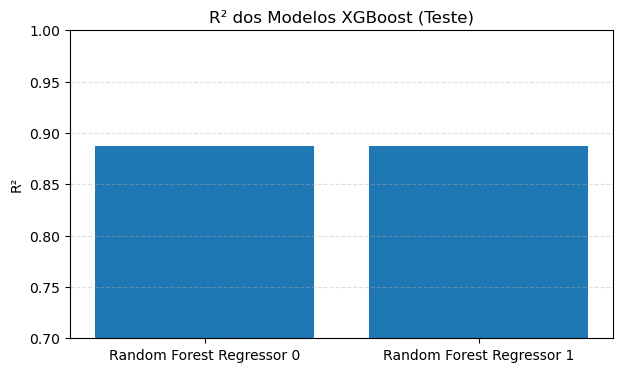

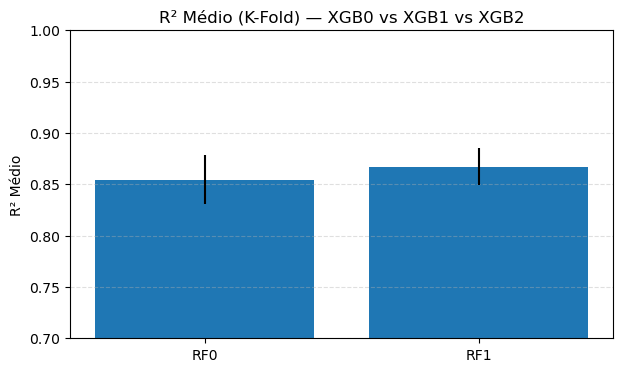

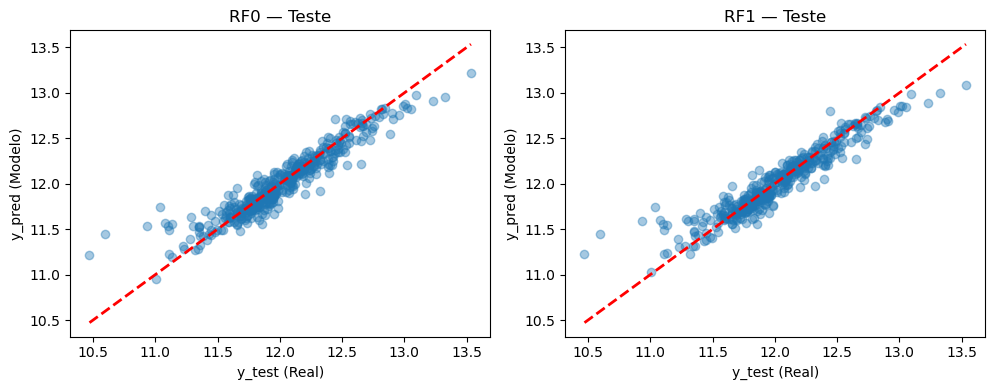

In [5]:
# =====================================================
# 1. Organizar resultados em DataFrame
# =====================================================

resultados_teste = pd.DataFrame([
    res0, res1])

resultados_cv = pd.DataFrame({
    "Modelo": ["RF0", "RF1"],
    "R2_Médio": [np.mean(r20), np.mean(r21),],
    "R2_Std":   [np.std(r20),  np.std(r21)]
})

display(resultados_teste)
display(resultados_cv)

# =====================================================
# 2. Gráfico — R² no conjunto de teste
# =====================================================

plt.figure(figsize=(7,4))
plt.bar(resultados_teste['Modelo'], resultados_teste['R²'])
plt.title("R² dos Modelos XGBoost (Teste)")
plt.ylabel("R²")
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

# =====================================================
# 3. Gráfico — R² médio da validação cruzada
# =====================================================

plt.figure(figsize=(7,4))
plt.bar(resultados_cv['Modelo'], resultados_cv['R2_Médio'], yerr=resultados_cv['R2_Std'])
plt.title("R² Médio (K-Fold) — XGB0 vs XGB1 vs XGB2")
plt.ylabel("R² Médio")
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

# =====================================================
# 4. Gráfico de Dispersão — y_test vs y_pred para cada modelo
# =====================================================

predicoes = {
    "RF0": RF0.predict(X_test),
    "RF1": RF1.predict(X_test)

}

plt.figure(figsize=(15,4))

for i, (nome, y_p) in enumerate(predicoes.items(), 1):
    plt.subplot(1, 3, i)
    plt.scatter(y_test, y_p, alpha=0.4)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', linewidth=2)
    plt.title(f"{nome} — Teste")
    plt.xlabel("y_test (Real)")
    plt.ylabel("y_pred (Modelo)")

plt.tight_layout()
plt.show()